# Soil Moisture IoT Project — AAI-530 Final Team Project

Machine learning IoT application using the **Soil Moisture Data from Field-Scale Sensor Network** (Kaggle).
- **Data**: Hourly and daily volumetric water content (VW) and soil temperature (T) at 5 depths, 42 locations.
- **Model 1**: Linear Regression — time series prediction of soil moisture (VW_30cm).
- **Model 2**: LSTM (TensorFlow/Keras) — deep learning time series prediction of soil temperature (T_30cm).

Run all cells in order. Ensure the `archive` folder (with `Hourly/` and `Daily/` subfolders) is in the same directory as this notebook.


In [1]:
# =========================================================================
# Imports and dataset path
# =========================================================================
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dataset path: local archive folder (run notebook from project directory)
dataset_path = os.path.join(os.getcwd(), "archive")
print("Dataset path:", dataset_path)
print("Archive exists:", os.path.isdir(dataset_path))

Dataset path: /Users/evinjoy/Documents/assignments/data analyticts iot/final proj /archive
Archive exists: True


## Data loading

We read all hourly and daily TXT files from the local `archive` folder, combine them into single DataFrames, standardize column names, handle missing values with forward/back fill (standard for sensor time series), and parse date/time columns for later time-based splits and plotting.


In [2]:
# =========================================================================
# Load Hourly and Daily data from archive
# =========================================================================
def load_and_combine(file_list, sep="\t"):
    df_list = []
    for f in file_list:
        try:
            df_list.append(pd.read_csv(f, sep=sep, engine="python"))
        except Exception as e:
            print(f"Error reading {f}: {e}")
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    return pd.DataFrame()

# Find all hourly and daily TXT files in archive
hourly_files = glob.glob(os.path.join(dataset_path, "Hourly", "*.txt"))
daily_files = glob.glob(os.path.join(dataset_path, "Daily", "*.txt"))

# Combine all files into single DataFrames (required for rubric: data loading)
hourly_df = load_and_combine(hourly_files)
daily_df = load_and_combine(daily_files)

print(f"Hourly files: {len(hourly_files)}, shape: {hourly_df.shape}")
print(f"Daily files: {len(daily_files)}, shape: {daily_df.shape}")

# Standardize column names for consistent processing
hourly_df.columns = hourly_df.columns.str.strip().str.lower()
daily_df.columns = daily_df.columns.str.strip().str.lower()

# Handle missing values: forward fill then back fill (standard for sensor time series)
hourly_df = hourly_df.ffill().bfill()
daily_df = daily_df.ffill().bfill()

# Parse date/time columns for sorting and time-based splits
for col in hourly_df.columns:
    if "time" in col or "date" in col:
        hourly_df[col] = pd.to_datetime(hourly_df[col], errors="coerce")
for col in daily_df.columns:
    if "time" in col or "date" in col:
        daily_df[col] = pd.to_datetime(daily_df[col], errors="coerce")

display(hourly_df.head())
display(daily_df.head())

Hourly files: 42, shape: (3373658, 13)
Daily files: 42, shape: (140532, 12)


/var/folders/ht/jjh91w2d7pd65d0hvb5873800000gn/T/ipykernel_8482/1287281603.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly_df[col] = pd.to_datetime(hourly_df[col], errors="coerce")


,location,date,time,vw_30cm,vw_60cm,vw_90cm,vw_120cm,vw_150cm,t_30cm,t_60cm,t_90cm,t_120cm,t_150cm
0,CAF095,2007-04-20,2026-02-23 00:00:00,0.302,0.28,0.344,0.263,0.326,12.4,10.3,9.6,8.8,8.9
1,CAF095,2007-04-20,2026-02-23 01:00:00,0.302,0.28,0.344,0.263,0.326,12.4,10.3,9.6,8.8,8.9
2,CAF095,2007-04-20,2026-02-23 02:00:00,0.302,0.28,0.344,0.263,0.326,12.4,10.3,9.6,8.8,8.9
3,CAF095,2007-04-20,2026-02-23 03:00:00,0.302,0.28,0.344,0.263,0.326,12.4,10.3,9.6,8.8,8.9
4,CAF095,2007-04-20,2026-02-23 04:00:00,0.302,0.28,0.344,0.263,0.326,12.4,10.3,9.6,8.8,8.9


,location,date,vw_30cm,vw_60cm,vw_90cm,vw_120cm,vw_150cm,t_30cm,t_60cm,t_90cm,t_120cm,t_150cm
0,CAF095,2007-04-20,0.302,0.282,0.348,0.274,0.331,11.51,9.7,8.925,8.238,7.962
1,CAF095,2007-04-21,0.302,0.282,0.348,0.274,0.331,11.51,9.7,8.925,8.238,7.962
2,CAF095,2007-04-22,0.302,0.282,0.348,0.274,0.331,11.51,9.7,8.925,8.238,7.962
3,CAF095,2007-04-23,0.302,0.282,0.348,0.274,0.331,11.51,9.7,8.925,8.238,7.962
4,CAF095,2007-04-24,0.302,0.282,0.348,0.274,0.331,11.51,9.7,8.925,8.238,7.962


## Data description

Variable definitions for the sensor dataset:

- **Location**: Sensor/site identifier (e.g. CAF095). One row per location per time step.
- **Date / Time**: Temporal index for time-series ordering and train/test splits.
- **VW_30cm … VW_150cm**: Volumetric water content (soil moisture, m³/m³) at 30–150 cm depth.
- **T_30cm … T_150cm**: Soil temperature (°C) at the same depths.

Below we show basic info and summary statistics for the loaded data.


In [3]:
# Basic info and summary
print("Hourly info:")
display(hourly_df.info())
print("\nDaily info:")
display(daily_df.info())
print("\nHourly describe (numeric):")
display(hourly_df.describe())

Hourly info:
<class 'pandas.DataFrame'>
RangeIndex: 3373658 entries, 0 to 3373657
Data columns (total 13 columns):
 #   Column    Dtype         
---  ------    -----         
 0   location  str           
 1   date      datetime64[us]
 2   time      datetime64[us]
 3   vw_30cm   float64       
 4   vw_60cm   float64       
 5   vw_90cm   float64       
 6   vw_120cm  float64       
 7   vw_150cm  float64       
 8   t_30cm    float64       
 9   t_60cm    float64       
 10  t_90cm    float64       
 11  t_120cm   float64       
 12  t_150cm   float64       
dtypes: datetime64[us](2), float64(10), str(1)
memory usage: 334.6 MB


None


Daily info:
<class 'pandas.DataFrame'>
RangeIndex: 140532 entries, 0 to 140531
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   location  140532 non-null  str           
 1   date      140532 non-null  datetime64[us]
 2   vw_30cm   140532 non-null  float64       
 3   vw_60cm   140532 non-null  float64       
 4   vw_90cm   140532 non-null  float64       
 5   vw_120cm  140532 non-null  float64       
 6   vw_150cm  140532 non-null  float64       
 7   t_30cm    140532 non-null  float64       
 8   t_60cm    140532 non-null  float64       
 9   t_90cm    140532 non-null  float64       
 10  t_120cm   140532 non-null  float64       
 11  t_150cm   140532 non-null  float64       
dtypes: datetime64[us](1), float64(10), str(1)
memory usage: 12.9 MB


None


Hourly describe (numeric):


,date,time,vw_30cm,vw_60cm,vw_90cm,vw_120cm,vw_150cm,t_30cm,t_60cm,t_90cm,t_120cm,t_150cm
count,3373658,3373658,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06,3.373658e+06
mean,2011-11-17 22:35:21.398197,2026-02-23 11:30:10.921676,2.554486e-01,2.919836e-01,3.147516e-01,3.334398e-01,3.473431e-01,1.173324e+01,1.119097e+01,1.082826e+01,1.063005e+01,1.038739e+01
min,2007-04-20 00:00:00,2026-02-23 00:00:00,7.700000e-02,4.000000e-03,6.100000e-02,9.300000e-02,7.400000e-02,-9.100000e+00,-7.000000e+00,-7.100000e+00,-2.800000e+00,6.000000e-01
25%,2009-08-03 00:00:00,2026-02-23 06:00:00,2.070000e-01,2.190000e-01,2.400000e-01,2.590000e-01,2.770000e-01,5.600000e+00,6.200000e+00,6.500000e+00,7.000000e+00,7.200000e+00
50%,2011-11-18 00:00:00,2026-02-23 12:00:00,2.370000e-01,2.870000e-01,3.140000e-01,3.360000e-01,3.480000e-01,1.320000e+01,1.200000e+01,1.150000e+01,1.130000e+01,1.070000e+01
75%,2014-03-04 00:00:00,2026-02-23 18:00:00,3.030000e-01,3.520000e-01,3.940000e-01,4.040000e-01,4.150000e-01,1.740000e+01,1.560000e+01,1.460000e+01,1.370000e+01,1.300000e+01
max,2016-06-16 00:00:00,2026-02-23 23:00:00,1.010000e+00,6.520000e-01,6.090000e-01,6.310000e-01,6.140000e-01,2.900000e+01,2.340000e+01,2.110000e+01,2.480000e+01,2.530000e+01
std,NaN,NaN,7.326366e-02,9.357967e-02,9.356832e-02,9.227059e-02,9.440533e-02,6.466930e+00,5.343538e+00,4.589122e+00,3.926585e+00,3.498996e+00


## Cleaning pipeline

We apply a consistent cleaning function to both hourly and daily data: standardize column names (lowercase, no spaces), drop fully empty and duplicate rows, convert date/time columns to datetime and object columns to numeric where possible, then forward- and back-fill remaining missing values. This ensures reliable downstream analysis and modeling.


In [4]:
# =========================================================================
# Cleaning pipeline (rubric: cleaning script complete and well-commented)
# =========================================================================
def clean_soil_data(df):
    df = df.copy()
    # Standardize column names; drop non-word chars for consistent field names
    df.columns = (
        df.columns.str.strip().str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^\w]", "", regex=True)
    )
    df.dropna(how="all", inplace=True)
    df.drop_duplicates(inplace=True)
    for col in df.columns:
        if "time" in col or "date" in col:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = pd.to_numeric(df[col])
            except (ValueError, TypeError):
                pass
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    time_cols = [c for c in df.columns if "time" in c or "date" in c]
    if time_cols:
        df.sort_values(by=time_cols[0], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

hourly_df = clean_soil_data(hourly_df)
daily_df = clean_soil_data(daily_df)
print("Hourly shape:", hourly_df.shape)
print("Daily shape:", daily_df.shape)
display(hourly_df.head())

Hourly shape: (3372768, 13)
Daily shape: (140532, 12)


,location,date,time,vw_30cm,vw_60cm,vw_90cm,vw_120cm,vw_150cm,t_30cm,t_60cm,t_90cm,t_120cm,t_150cm
0,CAF095,2007-04-20,2026-02-23 00:00:00,0.302,0.280,0.344,0.263,0.326,12.4,10.3,9.6,8.8,8.9
1,CAF133,2007-04-20,2026-02-23 23:00:00,0.192,0.246,0.264,0.300,0.292,12.9,12.7,12.7,11.3,11.0
2,CAF133,2007-04-20,2026-02-23 22:00:00,0.192,0.246,0.264,0.300,0.292,12.9,12.7,12.7,11.3,11.0
3,CAF133,2007-04-20,2026-02-23 21:00:00,0.192,0.246,0.264,0.300,0.292,12.9,12.7,12.7,11.3,11.0
4,CAF133,2007-04-20,2026-02-23 20:00:00,0.192,0.246,0.264,0.300,0.292,12.9,12.7,12.7,11.3,11.0


## Preprocessing

For modeling and EDA we add time-based features (year, month, day, hour), clip numeric columns to the IQR range to limit outlier impact, and apply StandardScaler so features are on a common scale. The preprocessed datasets are used in EDA and can be used for additional models.


In [5]:
# =========================================================================
# Preprocessing: time features, IQR clip, scaling
# =========================================================================
def preprocess_soil_data(df):
    df = df.copy()
    time_cols = [c for c in df.columns if "time" in c or "date" in c]
    time_col = time_cols[0] if time_cols else None
    if time_col:
        df["year"] = df[time_col].dt.year
        df["month"] = df[time_col].dt.month
        df["day"] = df[time_col].dt.day
        df["hour"] = df[time_col].dt.hour
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], low, high)
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

hourly_processed = preprocess_soil_data(hourly_df)
daily_processed = preprocess_soil_data(daily_df)
print("Hourly processed:", hourly_processed.shape)
print("Daily processed:", daily_processed.shape)
display(hourly_processed.head())

Hourly processed: (3372768, 17)
Daily processed: (140532, 16)


,location,date,time,vw_30cm,vw_60cm,vw_90cm,vw_120cm,vw_150cm,t_30cm,t_60cm,t_90cm,t_120cm,t_150cm,year,month,day,hour
0,CAF095,2007-04-20,2026-02-23 00:00:00,0.671462,-0.127258,0.313035,-0.763580,-0.225560,0.103248,-0.166561,-0.267440,-0.465818,-0.425127,-1.639782,-0.729001,0.484829,0.0
1,CAF133,2007-04-20,2026-02-23 23:00:00,-0.889361,-0.491976,-0.542096,-0.362121,-0.585995,0.180558,0.282544,0.408027,0.170862,0.175905,-1.639782,-0.729001,0.484829,0.0
2,CAF133,2007-04-20,2026-02-23 22:00:00,-0.889361,-0.491976,-0.542096,-0.362121,-0.585995,0.180558,0.282544,0.408027,0.170862,0.175905,-1.639782,-0.729001,0.484829,0.0
3,CAF133,2007-04-20,2026-02-23 21:00:00,-0.889361,-0.491976,-0.542096,-0.362121,-0.585995,0.180558,0.282544,0.408027,0.170862,0.175905,-1.639782,-0.729001,0.484829,0.0
4,CAF133,2007-04-20,2026-02-23 20:00:00,-0.889361,-0.491976,-0.542096,-0.362121,-0.585995,0.180558,0.282544,0.408027,0.170862,0.175905,-1.639782,-0.729001,0.484829,0.0


## Exploratory analysis

We explore the data with a time-series plot of soil moisture (VW_30cm) for one representative location. This shows how moisture varies over time and supports the choice of lag-based and sequence-based models for prediction.


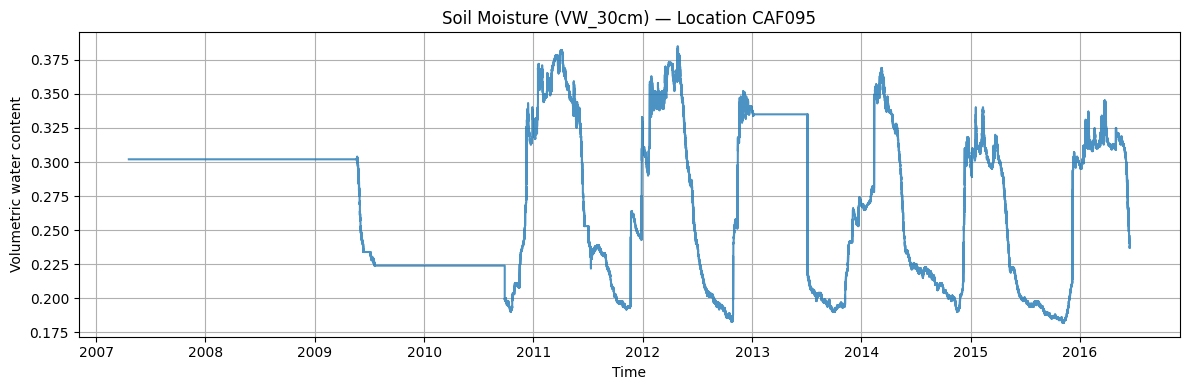

In [6]:
# =========================================================================
# EDA: time series of VW_30cm for one location
# =========================================================================
loc = hourly_df["location"].value_counts().index[0]
sub = hourly_df[hourly_df["location"] == loc].copy()
time_col = [c for c in sub.columns if "date" in c or "time" in c][0]
sub = sub.sort_values(time_col)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(sub[time_col], sub["vw_30cm"], alpha=0.8)
ax.set_title(f"Soil Moisture (VW_30cm) — Location {loc}")
ax.set_xlabel("Time")
ax.set_ylabel("Volumetric water content")
ax.grid(True)
plt.tight_layout()
plt.show()

## Model 1: Linear Regression — Soil moisture (VW_30cm) time series

**Purpose:** Time series prediction of next-step soil moisture (VW_30cm) to satisfy the rubric requirement for at least one time series prediction. We use lag features (past 1–6 steps) and a 6-step rolling mean, with a time-based 80/20 train/test split and no current or future target in the features to avoid leakage. Metrics (RMSE, MAE, R²) are reported on the test set.


In [7]:
# =========================================================================
# Linear Regression: predict next-step VW_30cm (time series)
# Rubric: at least one time series prediction; this model predicts soil moisture.
# =========================================================================
# Use one location and build lag features (past values only; no future/current target)
loc = hourly_df["location"].value_counts().index[0]
df = hourly_df[hourly_df["location"] == loc].copy()
time_col = [c for c in df.columns if "date" in c or "time" in c][0]
df = df.sort_values(time_col).dropna(subset=["vw_30cm"])

target = "vw_30cm"
for i in range(1, 7):
    df[f"lag_{i}"] = df[target].shift(i)
df["roll_mean_6"] = df[target].rolling(6).mean().shift(1)
df = df.dropna()

# Time-based train/test split (no shuffle) to avoid leakage
feat_cols = [c for c in df.columns if c.startswith("lag_") or c == "roll_mean_6"]
train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]
X_train, y_train = train[feat_cols], train[target]
X_test, y_test = test[feat_cols], test[target]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)

print("Linear Regression — Soil Moisture (VW_30cm)")
print("  RMSE:", round(np.sqrt(mean_squared_error(y_test, pred)), 5))
print("  MAE: ", round(mean_absolute_error(y_test, pred), 5))
print("  R²:  ", round(r2_score(y_test, pred), 4))

Linear Regression — Soil Moisture (VW_30cm)
  RMSE: 0.00161
  MAE:  0.00065
  R²:   0.9991


## Model 2: LSTM — Soil temperature (T_30cm) time series

**Purpose:** Deep learning time series prediction to satisfy the rubric requirement for at least one deep learning model built from scratch. We use TensorFlow/Keras to define and train an LSTM (no pre-built or pre-trained architecture). The model takes 24 hours of moisture and temperature features and predicts soil temperature at 30 cm depth 6 hours ahead. Data is scaled with MinMaxScaler; we use a time-based split and early stopping. This predicts a **different** variable (T_30cm) from Model 1 (VW_30cm).


In [8]:
# =========================================================================
# LSTM: predict T_30cm 6 hours ahead (deep learning from scratch)
# Rubric: at least one deep learning model; built with TensorFlow/Keras, no pre-trained model.
# =========================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

# Load hourly data again for this model
path_hourly = os.path.join(dataset_path, "Hourly")
files = glob.glob(os.path.join(path_hourly, "*.txt"))
df_lstm = pd.concat([pd.read_csv(f, sep="\t") for f in files], ignore_index=True)
df_lstm.columns = df_lstm.columns.str.strip().str.lower()
time_col = [c for c in df_lstm.columns if "time" in c or "date" in c][0]
df_lstm[time_col] = pd.to_datetime(df_lstm[time_col], errors="coerce")
df_lstm = df_lstm.sort_values(time_col).ffill().bfill().dropna()

# One location for manageable training (same approach as LR)
loc = df_lstm["location"].value_counts().index[0]
df_loc = df_lstm[df_lstm["location"] == loc].copy()
target_col = "t_30cm"
feat_cols = [c for c in df_loc.columns if c.startswith("vw_") or c.startswith("t_")]

# Create 6-hour-ahead target (time series prediction)
HORIZON = 6
df_loc["y"] = df_loc[target_col].shift(-HORIZON)
df_loc = df_loc.dropna(subset=["y"])

X_raw = df_loc[feat_cols].values.astype(np.float32)
y_raw = df_loc["y"].values.astype(np.float32)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).flatten()

# Build sequences: 24 steps of history -> next value (LSTM input shape: samples, timesteps, features)
LOOKBACK = 24
X_seq, y_seq = [], []
for i in range(LOOKBACK, len(X_scaled)):
    X_seq.append(X_scaled[i - LOOKBACK:i])
    y_seq.append(y_scaled[i])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Time-based split for evaluation
split = int(0.8 * len(X_seq))
X_train_lstm, X_test_lstm = X_seq[:split], X_seq[split:]
y_train_lstm, y_test_lstm = y_seq[:split], y_seq[split:]

# Build LSTM from scratch (no pre-built or pre-trained model; rubric requirement)
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, len(feat_cols))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1),
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.1, epochs=50, batch_size=64,
    callbacks=[early], verbose=1
)

# Evaluate: inverse-scale predictions and compute metrics
y_pred_s = model.predict(X_test_lstm, verbose=0).flatten()
y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()

print("\nLSTM — Soil Temperature (T_30cm), 6h ahead")
print("  RMSE:", round(np.sqrt(mean_squared_error(y_actual, y_pred)), 4))
print("  MAE: ", round(mean_absolute_error(y_actual, y_pred), 4))
print("  R²:  ", round(r2_score(y_actual, y_pred), 4))

/Users/evinjoy/Documents/assignments/data analyticts iot/final proj /venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0055 - mae: 0.0521 - val_loss: 0.0021 - val_mae: 0.0329
Epoch 2/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0025 - mae: 0.0366 - val_loss: 7.6821e-04 - val_mae: 0.0185
Epoch 3/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0017 - mae: 0.0295 - val_loss: 6.9075e-04 - val_mae: 0.0173
Epoch 4/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 7.7529e-04 - val_mae: 0.0180
Epoch 5/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 6.4641e-04 - val_mae: 0.0175
Epoch 6/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 7.6344e-04 - val_mae: 0.0209
Epoch 7/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 7.8110e-04 - val_mae: 0.0197
Epoch 8/50
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 9.8835e-04 - mae: 0.0232 - val_loss: 6.2050e-04 - val_mae: 0.0168
Epoch 9/50
914/914 ━━━━━

## Summary

This notebook delivers the **data processing** and **machine learning** components required for the final project:

- **Data**: Loaded from local `archive/Hourly` and `archive/Daily`, with cleaning (standardized names, missing-value handling, duplicates removed) and preprocessing (time features, IQR clipping, scaling).
- **Exploratory analysis**: Info, summary statistics, and time-series visualization of soil moisture.
- **Model 1 (Linear Regression)**: Time series prediction of soil moisture (VW_30cm) with lag and rolling features; time-based split; no data leakage.
- **Model 2 (LSTM)**: Deep learning model built from scratch with TensorFlow/Keras; predicts soil temperature (T_30cm) 6 hours ahead from 24-hour sequences.

Both models use time-based splits and predict **different** variables (moisture vs. temperature), satisfying the rubric for one deep learning model, one time series prediction, and two distinct prediction targets.
